<a href="https://colab.research.google.com/github/MariiaZimokha/notebooks/blob/main/kaggle/Sales_Prediction_using_Xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle
! pip install xgboost==1.5.1

     |████████████████████████████████| 173.5 MB 13 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [1]:
file_path = "/content/drive/MyDrive/Studying/kaggle.json"


In [4]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Studying/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [5]:
!kaggle competitions download -c store-sales-time-series-forecasting

  0% 0.00/1.35k [00:00<?, ?B/s]
100% 1.35k/1.35k [00:00<00:00, 2.20MB/s]
 43% 9.00M/20.8M [00:00<00:00, 83.5MB/s]
100% 20.8M/20.8M [00:00<00:00, 102MB/s] 
  0% 0.00/998k [00:00<?, ?B/s]
100% 998k/998k [00:00<00:00, 49.5MB/s]
  0% 0.00/334k [00:00<?, ?B/s]
100% 334k/334k [00:00<00:00, 108MB/s]
  0% 0.00/360k [00:00<?, ?B/s]
100% 360k/360k [00:00<00:00, 86.4MB/s]
  0% 0.00/21.8k [00:00<?, ?B/s]
100% 21.8k/21.8k [00:00<00:00, 34.2MB/s]
  0% 0.00/20.1k [00:00<?, ?B/s]
100% 20.1k/20.1k [00:00<00:00, 36.8MB/s]


## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path


## Read Data

In [3]:
from zipfile import ZipFile

base_path = "/content/"

zipfiles = ["train.csv.zip", "transactions.csv.zip"]

for file in zipfiles:
  with ZipFile(f"{base_path}{file}", 'r') as zip_ref:
    zip_ref.extractall(base_path)

In [10]:
holidays=pd.read_csv(f"{base_path}holidays_events.csv")
oil=pd.read_csv(f"{base_path}oil.csv")
stores=pd.read_csv(f"{base_path}stores.csv")
test=pd.read_csv(f"{base_path}test.csv")
train=pd.read_csv(f"{base_path}train.csv")
transactions=pd.read_csv(f"{base_path}transactions.csv")

In [11]:
#Merging all available datasets to perform exploratory data analysis
m1 = pd.merge(holidays, oil)
m2 = pd.merge(train, stores)
m3 = pd.merge(m2, transactions)
df = pd.merge(m3, m1, on="date")

In [8]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01


In [9]:
df.shape

(322047, 17)

## Data exploration

In [19]:
df.describe()

,id,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico
count,3.220470e+05,322047.000000,322047.000000,322047.000000,322047.000000,322047.000000,300003.000000
mean,1.682979e+06,26.994672,406.383452,3.727136,8.531202,1734.117840,64.077912
std,7.862493e+05,15.595174,1246.881240,15.512095,4.713809,1050.335018,25.147682
min,5.610000e+02,1.000000,0.000000,0.000000,1.000000,54.000000,27.960000
25%,1.010616e+06,13.000000,1.000000,0.000000,4.000000,1030.000000,44.660000
50%,1.842406e+06,27.000000,19.000000,0.000000,9.000000,1409.000000,51.440000
75%,2.209556e+06,40.000000,241.260505,1.000000,13.000000,2148.000000,94.740000
max,3.000887e+06,54.000000,124717.000000,716.000000,17.000000,8359.000000,107.950000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            322047 non-null  int64  
 1   date          322047 non-null  object 
 2   store_nbr     322047 non-null  int64  
 3   family        322047 non-null  object 
 4   sales         322047 non-null  float64
 5   onpromotion   322047 non-null  int64  
 6   city          322047 non-null  object 
 7   state         322047 non-null  object 
 8   type_x        322047 non-null  object 
 9   cluster       322047 non-null  int64  
 10  transactions  322047 non-null  int64  
 11  type_y        322047 non-null  object 
 12  locale        322047 non-null  object 
 13  locale_name   322047 non-null  object 
 14  description   322047 non-null  object 
 15  transferred   322047 non-null  bool   
 16  dcoilwtico    300003 non-null  float64
dtypes: bool(1), float64(2), int64(5), object(9)
memo

In [21]:
# dcoilwtico column has missing data. We will fill it with mean value
df.loc[(df["dcoilwtico"].isnull()), "dcoilwtico"] = df["dcoilwtico"].mean()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            322047 non-null  int64  
 1   date          322047 non-null  object 
 2   store_nbr     322047 non-null  int64  
 3   family        322047 non-null  object 
 4   sales         322047 non-null  float64
 5   onpromotion   322047 non-null  int64  
 6   city          322047 non-null  object 
 7   state         322047 non-null  object 
 8   type_x        322047 non-null  object 
 9   cluster       322047 non-null  int64  
 10  transactions  322047 non-null  int64  
 11  type_y        322047 non-null  object 
 12  locale        322047 non-null  object 
 13  locale_name   322047 non-null  object 
 14  description   322047 non-null  object 
 15  transferred   322047 non-null  bool   
 16  dcoilwtico    322047 non-null  float64
dtypes: bool(1), float64(2), int64(5), object(9)
memo

In [ ]:
# find unique values
columns = list(df.columns.values)

for column in columns:
   print(f"{column} ", df[column].unique())

# there are no unique values

In [12]:
# date column is object type. We need to convert it to date type

df["date_date"] = pd.to_datetime(df["date"])

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322047 entries, 0 to 322046
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  object        
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   type_x        322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  type_y        322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

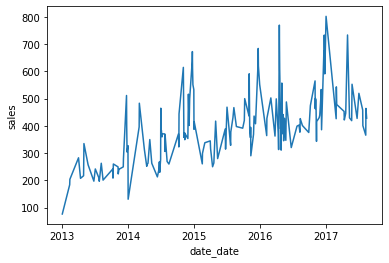

In [13]:
# Plote the time series of sales

sns.lineplot(x='date_date',y='sales',data=df,ci=None,estimator='mean')

Next, we will try to analyse the monthwise sales to find out which months on an average have contributed to high sales. This can be done by splitting the 'date' column into year, month and day columns.

In [41]:
df[["year","month", "day"]] = df["date"].str.split("-", expand = True)

df['month'] = pd.Categorical(df['month'],
                                   categories=['01','02','03','04','05','06','07','08','09','10','11','12'],
                                   ordered=True)
df['day'] = pd.Categorical(df['day'],categories=['01','02','03','04','05','06','07','08','09','10','11', '12', '14','15','16','17','18','19','20','21','22','23', '24', '25', '26', '27','28','29','30','31'],ordered=True)

df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico,date_date,year,month,day
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01,2013-02-11,2013,02,11
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01,2013-02-11,2013,02,11
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01,2013-02-11,2013,02,11
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01,2013-02-11,2013,02,11
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01,2013-02-11,2013,02,11


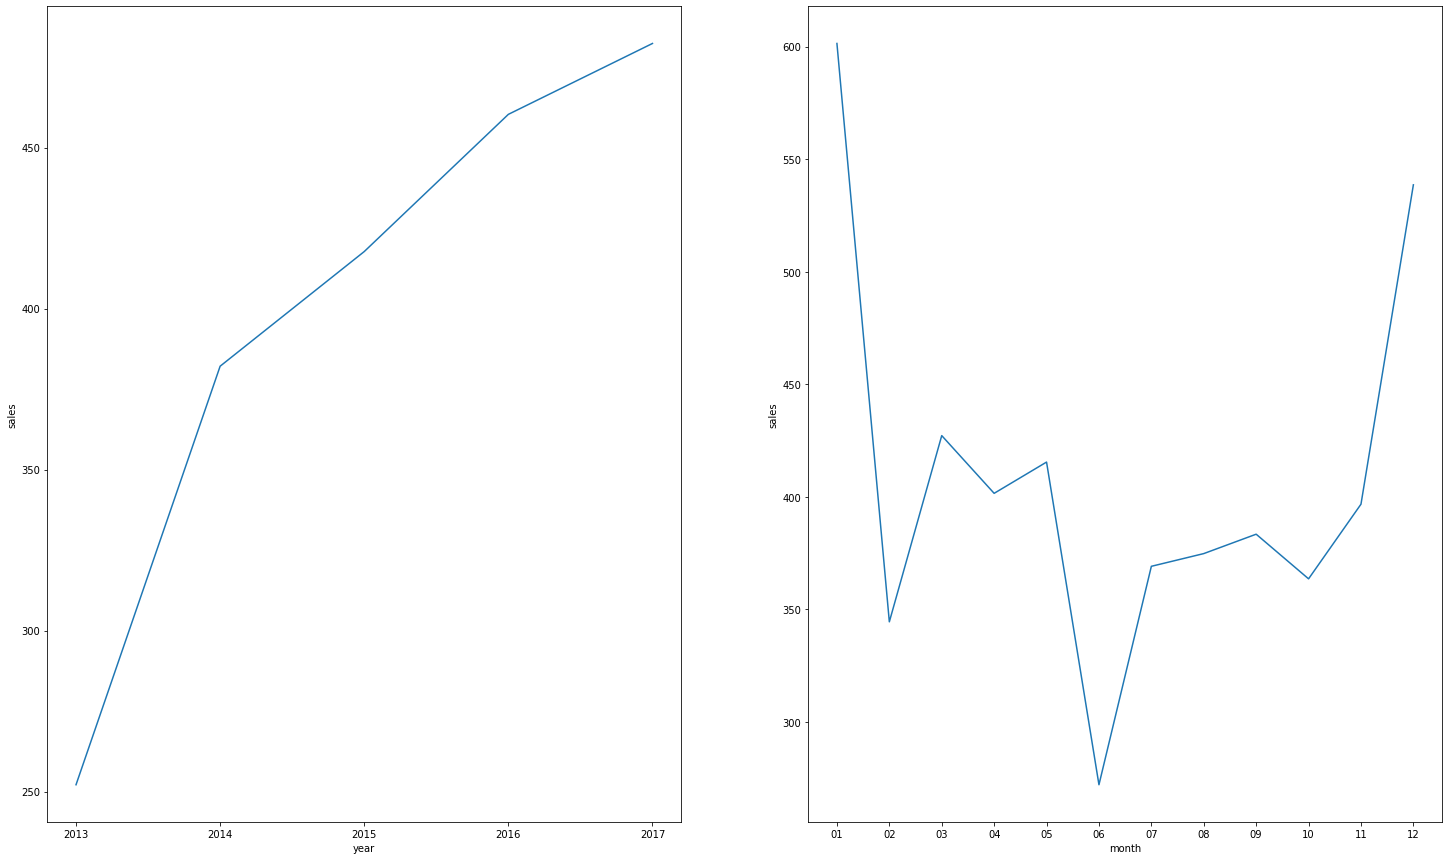

In [42]:
f,ax=plt.subplots(1,2,figsize=(25,15))
sns.lineplot(x='year', y='sales', data=df, ci=None, estimator='mean' ,ax=ax[0])
sns.lineplot(x='month', y='sales', data=df, ci=None, estimator='mean', ax=ax[1])


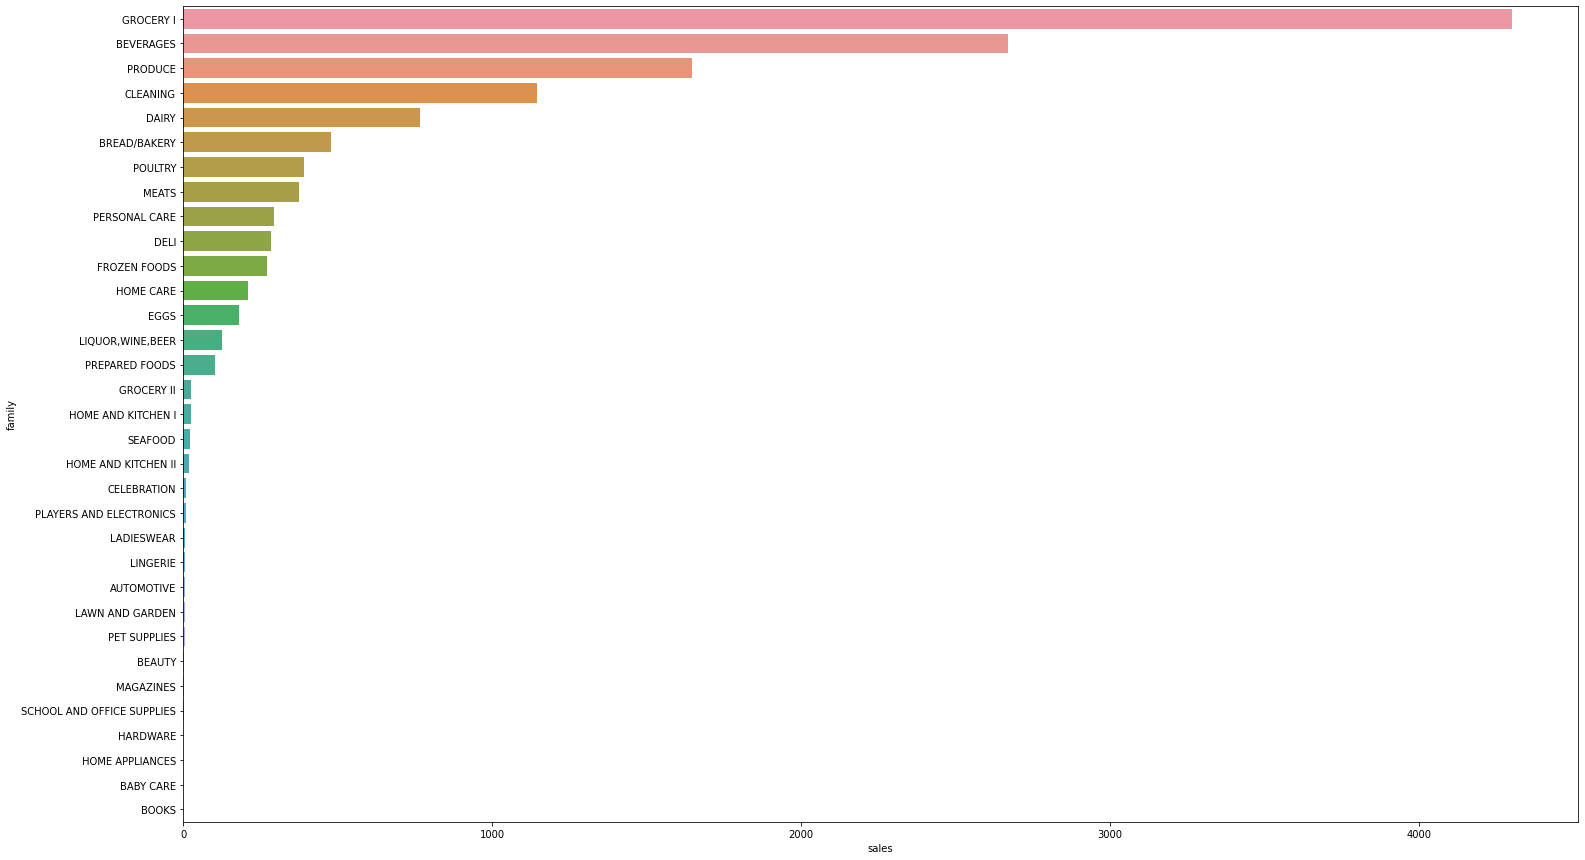

In [43]:
#Plotting the sales using bar-plot w.r.t to 'family' categories.

d=df.groupby('family')['sales'].mean().sort_values(ascending=False)
d=pd.DataFrame(d)
df.sales= pd.to_numeric(df.sales, errors='coerce')
ax,f=plt.subplots(figsize=(25,15))
sns.barplot(x='sales',y=d.index,data=d,ax=None,ci=None)

## Model - first attempt - with date field

In [10]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [25]:
from sklearn.model_selection import train_test_split


X = train.drop("sales", axis=1)
y = train["sales"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# one-hot encode the categorical features
cat_attribs = ['id','date','family']
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)], remainder='passthrough')

encoder = full_pipeline.fit(X_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)
test=encoder.transform(test)

In [32]:
print(X_test[2])

  (0, 2011277)	1.0
  (0, 2012302)	1.0
  (0, 2012311)	33.0
  (0, 2012312)	2.0


In [29]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=10, max_depth=20, verbosity=2)
xgb_model.fit(X_train, y_train)

[19:15:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:17:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16274 extra nodes, 0 pruned nodes, max_depth=20
[19:20:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 17570 extra nodes, 0 pruned nodes, max_depth=20
[19:23:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18778 extra nodes, 0 pruned nodes, max_depth=20
[19:26:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 19358 extra nodes, 0 pruned nodes, max_depth=20
[19:28:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18876 extra nodes, 0 pruned nodes, max_depth=20
[19:31:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18700 extra nodes, 0 pruned nodes, max_depth=20
[19:34:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end,

XGBRegressor(max_depth=20, n_estimators=10, verbosity=2)

In [34]:
xgb_model.score(X_test, y_test) #accuracy

0.7260193427454023

In [35]:
pred1 = xgb_model.predict(test)
pred = pd.DataFrame(pred1)

In [36]:
pred.head()

,0
0,3.802088
1,3.802088
2,18.702511
3,1382.263794
4,3.802088


In [37]:
test1 = pd.read_csv(f"{base_path}test.csv")
pred.rename(columns={0:'sales'},inplace=True)
pred.index = test1['id']

In [38]:
pred.head()

,sales
id,
3000888,3.802088
3000889,3.802088
3000890,18.702511
3000891,1382.263794
3000892,3.802088


In [39]:
pred.to_csv('submission.csv')

## Model - xgboost.train

In [32]:
from sklearn.model_selection import train_test_split
import pandas as pd

base_path = "/content/"

test = pd.read_csv(f"{base_path}test.csv")
train = pd.read_csv(f"{base_path}train.csv")

In [33]:
def get_more_features(data_set):
  data_set[["year","month", "day"]] = data_set["date"].str.split("-", expand = True)
  data_set["date"] = pd.to_datetime(data_set["date"])
  return data_set

def date_features(data_set):
  data_set['date'] = pd.to_datetime(data_set['date'])
  data_set['year'] = data_set['date'].dt.year
  data_set['month'] = data_set['date'].dt.month
  data_set['week'] = data_set['date'].dt.isocalendar().week
  data_set['quarter'] = data_set['date'].dt.quarter
  data_set['day_of_week'] = data_set['date'].dt.day_name()
  return data_set

In [34]:
train = date_features(train)
train.drop(['id', 'date'], axis=1, inplace=True)
train.head()

,store_nbr,family,sales,onpromotion,year,month,week,quarter,day_of_week
0,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Tuesday
1,1,BABY CARE,0.0,0,2013,1,1,1,Tuesday
2,1,BEAUTY,0.0,0,2013,1,1,1,Tuesday
3,1,BEVERAGES,0.0,0,2013,1,1,1,Tuesday
4,1,BOOKS,0.0,0,2013,1,1,1,Tuesday


In [35]:
test = date_features(test)
test.drop(['id', 'date'], axis=1, inplace=True)
test.head()

,store_nbr,family,onpromotion,year,month,week,quarter,day_of_week
0,1,AUTOMOTIVE,0,2017,8,33,3,Wednesday
1,1,BABY CARE,0,2017,8,33,3,Wednesday
2,1,BEAUTY,2,2017,8,33,3,Wednesday
3,1,BEVERAGES,20,2017,8,33,3,Wednesday
4,1,BOOKS,0,2017,8,33,3,Wednesday


In [36]:
X = train.drop("sales", axis=1)
y = train["sales"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# one-hot encode the categorical features
cat_attribs = ['family', "day_of_week"]
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)], remainder='passthrough')

encoder = full_pipeline.fit(X_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)
test = encoder.transform(test)

In [39]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

eval_set = [
  (dtrain, "train"),
  (dtest, "test")
]

params = {
    'eta': 0.3,
    'gamma': 3.5,
    "max_depth": 20,
    # "objective":"reg:squaredlogerror"
}

# {'alpha': 1.268127465943402, 'eta': 0.6493932585916127, 'gamma': 119.42709540832487, 'lambda': 39.87769404014604, 'max_depth': 21}
# xgb_train_params 
# {'num_boost_round': 315, 'early_stopping_rounds': 10}

model = xgb.train(
    params,
    dtrain=dtrain,
    evals=eval_set,
    num_boost_round=10,
)

print(model)

[13:29:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18556 extra nodes, 394 pruned nodes, max_depth=20
[0]	train-rmse:836.60962	test-rmse:843.01996
[13:29:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24602 extra nodes, 556 pruned nodes, max_depth=20
[1]	train-rmse:614.61182	test-rmse:629.39532
[13:29:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34900 extra nodes, 822 pruned nodes, max_depth=20
[2]	train-rmse:461.30463	test-rmse:488.53168
[13:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 49034 extra nodes, 938 pruned nodes, max_depth=20
[3]	train-rmse:355.15854	test-rmse:397.69177
[13:30:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66964 extra nodes, 1162 pruned nodes, max_depth=20
[4]	train-rmse:280.04358	test-rmse:341.61136
[13:30:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84950 extra nodes, 1348 pruned nodes, max_depth=20
[5]	train-rmse:226.24625	test-rmse:307.85986
[13:30:13] INF

In [40]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=10, max_depth=20, verbosity=2)
xgb_model.fit(X_train, y_train)

[13:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18950 extra nodes, 0 pruned nodes, max_depth=20
[13:30:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 25130 extra nodes, 0 pruned nodes, max_depth=20
[13:30:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 35686 extra nodes, 0 pruned nodes, max_depth=20
[13:30:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 49964 extra nodes, 0 pruned nodes, max_depth=20
[13:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68030 extra nodes, 0 pruned nodes, max_depth=20
[13:31:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86110 extra nodes, 0 pruned nodes, max_depth=20
[13:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 99950 extra nodes, 0 pruned nodes, max_depth=20
[13:31:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 109652 extra nodes, 0 pruned nodes, max_depth=20
[13:31:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=2)

In [41]:
from sklearn.metrics import mean_squared_error

ypred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print(f"MSE: {mse}")

print(f"RMSE: {(mse**(1/2.0))}")


MSE: 69105.99754013159
RMSE: 262.88019617333595


In [93]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_prediction(ytest, ypred, x_ax, start=0, end=None):
  figure(figsize=(20, 6), dpi=80)

  # x_ax = range(len(ytest))
  plt.plot(x_ax[start:end], ytest[start:end], label="original")
  plt.plot(x_ax[start:end], ypred[start:end], label="predicted")
  plt.title("sales")
  plt.legend()
  plt.grid(True)
  plt.show()

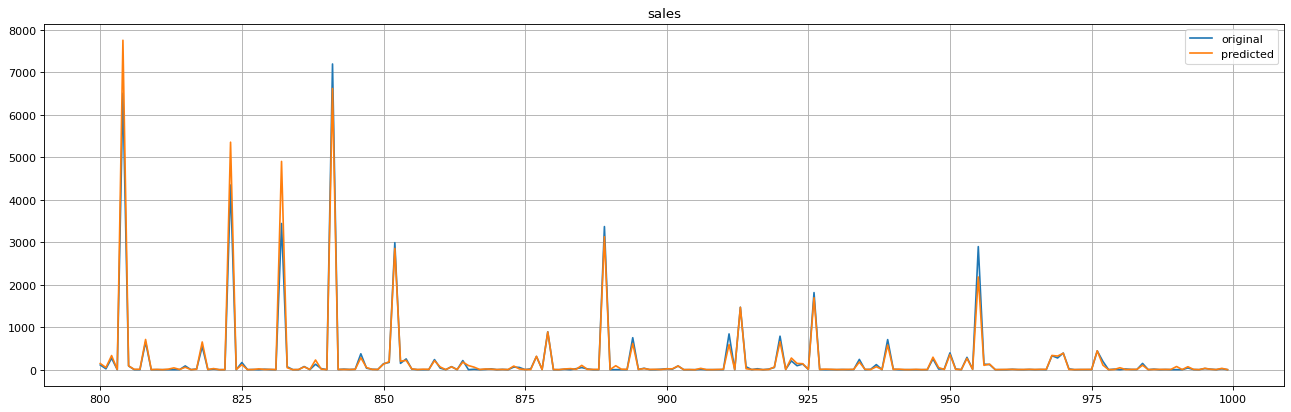

In [96]:
import numpy as np

y_sales = pd.DataFrame(y_test)['sales']
# pred_sales = pd.DataFrame(ypred)['sales']

x_ax = range(len(y_sales))

# arr = np.arange(100, x_ax, 100)
# print(arr)

plot_prediction(y_sales, ypred, x_ax, start=800, end=1000)

# plot_prediction(pd.DataFrame(y_test)['sales'], ypred)

In [42]:
from sklearn.metrics import accuracy_score

pred = model.predict(dtest)
# pred = xgb_model.predict(X_test)

# accuracy = accuracy_score(y_test, pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [10]:
pred = pd.DataFrame(pred)
pred.head()

,0
0,1656.673584
1,0.018720
2,214.418961
3,14.895466
4,16.948225


In [40]:
# y_test[:5]
y_pred = pd.DataFrame(y_test)
y_pred.head()

# 2483653    2576.000
# 2761877       0.000
# 1217988     357.354
# 1231938       5.000
# 528175        0.000

,sales
2483653,2576.000
2761877,0.000
1217988,357.354
1231938,5.000
528175,0.000


In [10]:
pred = pd.DataFrame(pred)
pred.head()

,0
0,1953.316284
1,5.650839
2,234.289505
3,18.069841
4,24.756010


### Submission results

In [23]:
pred = xgb_model.predict(test)
pred =  pd.DataFrame(pred)
# pred.head()

test1 = pd.read_csv(f"{base_path}test.csv")
pred.rename(columns={0:'sales'}, inplace=True)
pred.index = test1['id']

pred.head()

,sales
id,
3000888,6.713954
3000889,2.811912
3000890,15.217660
3000891,1993.325562
3000892,2.615149


In [24]:
pred.to_csv('submission-2.csv')

## **Util functions**

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

def get_training_data():
  base_path = "/content/"
  test = pd.read_csv(f"{base_path}test.csv")
  train = pd.read_csv(f"{base_path}train.csv")
  return train

def date_features(data_set):
  data_set["date"] = pd.to_datetime(data_set["date"])
  data_set["year"] = data_set["date"].dt.year
  data_set["month"] = data_set["date"].dt.month
  data_set["week"] = data_set["date"].dt.isocalendar().week
  data_set["quarter"] = data_set["date"].dt.quarter
  data_set["day_of_week"] = data_set["date"].dt.day_name()
  return data_set

def feature_pipeline(df):
  df = date_features(df)

  # didn't sore good
  # df["family"].replace(["AUTOMOTIVE", "HARDWARE", "LAWN AND GARDEN", "PLAYERS AND ELECTRONICS"], "Tools", inplace = True)
  # df["family"].replace(["BEAUTY", "LINGERIE", "LADIESWEAR","PERSONAL CARE","CELEBRATION","MAGAZINES","BOOKS", "BABY CARE"], "LifeStyle", inplace = True)
  # df["family"].replace(["HOME APPLIANCES","HOME AND KITCHEN I", "HOME AND KITCHEN II","HOME CARE","SCHOOL AND OFFICE SUPPLIES"], "Home", inplace=True)
  # df["family"].replace(["GROCERY II", "PET SUPPLIES","SEAFOOD","LIQUOR,WINE,BEER"], "Food", inplace=True)
  # df["family"].replace(["DELI", "EGGS"], "Daily", inplace=True)
  
  df.drop(["date", "id"], axis=1, inplace=True)
  return df

def encode(df):
  # one-hot encode the categorical features
  cat_attribs = ["family", "day_of_week"]
  full_pipeline = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs)], remainder="passthrough")

  encoder = full_pipeline.fit(df)
  return encoder


def get_pred(df, model):
  temp = df
  if "sales" in df:
    temp = df.drop("sales", axis=1)

  encoder = encode(temp)
  temp = encoder.transform(temp)

  ddf = xgb.DMatrix(temp)

  pred = model.predict(ddf)
  return pd.DataFrame(pred)

## Hyperopt

In [8]:
! pip install hyperopt

In [10]:
from typing import Dict
import pandas as pd
import xgboost as xgb

def model_training(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    xgb_params: Dict,
    xgb_train_params: Dict):

  train = date_features(train_df)
  test = date_features(test_df)

  X_train = train.drop("sales", axis=1)
  y_train = train["sales"]

  X_test = test.drop("sales", axis=1)
  y_test = test["sales"]

  encoder = encode(X_train)
  
  X_train = encoder.transform(X_train)
  X_test = encoder.transform(X_test)

  dtrain = xgb.DMatrix(X_train, label=y_train)
  dtest = xgb.DMatrix(X_test, label=y_test)

  eval_set = [
    (dtrain, "train"),
    (dtest, "test")
  ]

  model = xgb.train(
      params=xgb_params,
      dtrain=dtrain,
      evals=eval_set,
      **xgb_train_params
  )

  return model



In [11]:
from numpy.ma.extras import average
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from typing import Dict


def rmse(y_true, y_pred) -> float:
  return mean_squared_error(y_true, y_pred, squared=False)

def objective(c) -> Dict:
  print('objective ')
  train = get_training_data()
  train_len = len(train)

  xgb_params = c.get("xgb_params")
  xgb_params["max_depth"] = int(xgb_params["max_depth"])

  xgb_train_params = c.get("xgb_train_params")
  xgb_train_params["num_boost_round"] = int(xgb_train_params["num_boost_round"])
  xgb_train_params["early_stopping_rounds"] = 10

  print('xgb_params ', xgb_params)
  print('xgb_train_params ', xgb_train_params)


  k_fold = KFold(n_splits=3, random_state=2021, shuffle=True)

  scores = []

  for train_index, test_index in k_fold.split(list(range(train_len))):
    train_df, test_df = train.iloc[train_index, :], train.iloc[test_index, :]

    model = model_training(train_df, test_df, xgb_params, xgb_train_params)

    y_true = test_df["sales"]
    y_pred = get_pred(test_df, model)
    score = rmse(y_true, y_pred)
    print('score ', score)
    scores.append(score)
  
  average_score = sum(scores)/len(scores)
  print('average_score ', average_score)
  return {"loss": average_score}

In [ ]:
from hyperopt import fmin, hp, tpe

max_eval = 30

search_space = {
    "xgb_params": {
        "max_depth": hp.uniform("max_depth", 5, 30),
        "eta": hp.uniform("eta", 0, 1),
        "gamma": hp.loguniform("gamma", 0, 5),
        "alpha": hp.loguniform("alpha", 0, 1),
        "lambda": hp.loguniform("lambda", 0, 4),
    },
    "xgb_train_params": {
        "num_boost_round": hp.uniform("num_boost_round", 10, 500)
    }
}
c = {
    "xgb_params": {'alpha': 1.1432443618976713, 'eta': 0.12847037371172, 'gamma': 1.931876051374774, 'lambda': 2.977635207181022, 'max_depth': 26},
    "xgb_train_params": {'num_boost_round': 239}
}

# data = objective(c)

best = fmin(
    fn=objective, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=max_eval
)

print('best values', best)

## Train model after tuning

In [6]:
params = {"alpha": 2.034528033738704, 
          "eta": 0.2238040612107176, 
          "gamma": 29.752937673800854, 
          "lambda": 4.128178010157372, 
          "max_depth": 12.02231812796111, 
          "num_boost_round": 454.42378567655356}

xgb_params = {
    "alpha": 1.0171968732730914, 
    "eta": 0.2072848857914201, 
    "gamma": 39.37620740837167, 
    "lambda": 52.40966667672209, 
    "max_depth": 21
}

xgb_train_params = {
    "num_boost_round": 485,
    "early_stopping_rounds": 10
}

# xgb_params = {
#     "alpha": 1.6134620048999142, 
#     "eta": 0.36206977755718406, 
#     "gamma": 1.0503078303608664, 
#     "lambda": 53.99336889505091, 
#     "max_depth": 28
# }

# xgb_train_params = {
#     "num_boost_round": 167,
#     "early_stopping_rounds": 10
# }

In [10]:
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb

# get data
train = get_training_data()

# feature engineering
train = feature_pipeline(train)

# test and train datasets
X = train.drop(["sales"], axis=1)
y = train["sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# encode data
encoder = encode(X_train)
  
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# train  model
eval_set = [
  (dtrain, "train"),
  (dtest, "test")
]

model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    evals=eval_set,
    **xgb_train_params
)
# model = model_training(train_df, test_df, xgb_params, xgb_train_params)

[0]	train-rmse:826.49634	test-rmse:828.59607
[1]	train-rmse:622.84924	test-rmse:624.75110
[2]	train-rmse:496.21197	test-rmse:498.86887
[3]	train-rmse:417.81811	test-rmse:421.50104
[4]	train-rmse:368.16177	test-rmse:373.11157
[5]	train-rmse:334.14853	test-rmse:341.05926
[6]	train-rmse:309.79941	test-rmse:319.03940
[7]	train-rmse:293.35071	test-rmse:305.01028
[8]	train-rmse:278.79556	test-rmse:293.01233
[9]	train-rmse:266.86423	test-rmse:283.47888
[10]	train-rmse:257.19894	test-rmse:276.41458
[11]	train-rmse:248.94748	test-rmse:270.55597
[12]	train-rmse:241.59111	test-rmse:265.73618
[13]	train-rmse:235.07886	test-rmse:261.46588
[14]	train-rmse:229.52090	test-rmse:258.39578
[15]	train-rmse:224.34604	test-rmse:255.41007
[16]	train-rmse:219.41647	test-rmse:252.66629
[17]	train-rmse:215.04436	test-rmse:250.51918
[18]	train-rmse:210.91530	test-rmse:248.64535
[19]	train-rmse:207.06706	test-rmse:246.81700
[20]	train-rmse:203.66121	test-rmse:245.52850
[21]	train-rmse:200.01724	test-rmse:243.9732

### Test results - submission

In [14]:
test = pd.read_csv(f"{base_path}test.csv")
# test = date_features(test)
test = feature_pipeline(test)
pred = get_pred(test, model)
pred.head()


,0
0,5.566135
1,7.022674
2,-8.335647
3,2147.223633
4,7.022674


In [15]:
test1 = pd.read_csv(f"{base_path}test.csv")
pred.rename(columns={0:'sales'}, inplace=True)
pred.index = test1['id']

pred.head()

,sales
id,
3000888,5.566135
3000889,7.022674
3000890,-8.335647
3000891,2147.223633
3000892,7.022674


In [16]:
pred.to_csv('submission-4.csv')

## Windowing data

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb

# get data
train = get_training_data()


In [12]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [19]:
train.shape

(3000888, 6)

### Create Mean Encodings features

In [6]:
# mean
train["sum"] = train.groupby(['date','family'])["sales"].transform('sum')
train["mean"] = train.groupby(['date','family'])["sales"].transform('mean')
train["max"] = train.groupby(['date','family'])["sales"].transform('max')
train["min"] = train.groupby(['date','family'])["sales"].transform('min')


In [42]:
train.loc[train['sales'] != 0]

,id,date,store_nbr,family,sales,onpromotion,sum,mean,max,min
563,563,2013-01-01,25,BEAUTY,2.000,0,2.000000,0.037037,2.000,0.000
564,564,2013-01-01,25,BEVERAGES,810.000,0,810.000000,15.000000,810.000,0.000
566,566,2013-01-01,25,BREAD/BAKERY,180.589,0,180.589000,3.344241,180.589,0.000
568,568,2013-01-01,25,CLEANING,186.000,0,186.000000,3.444444,186.000,0.000
569,569,2013-01-01,25,DAIRY,143.000,0,143.000000,2.648148,143.000,0.000
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,17586.709986,325.679815,1155.024,36.813
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,4641.522980,85.954129,329.522,16.000
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,125108.971000,2316.832796,7265.289,256.911
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2530.000000,46.851852,418.000,0.000


### Create Lag Features

In [7]:
lag_variables = ["sales", "sum",	"mean",	"max",	"min"]

lags = [1 ,2 ,3 ,4, 5, 12]

# we will keep the results in this dataframe
sales_means = train.copy()

for lag in lags:
    for lag_var in lag_variables:
       sales_means[f"{lag_var}_lag_{lag}"] = sales_means[lag_var].shift(lag)
    

In [50]:
sales_means.dropna(inplace=True)
sales_means.head()

,id,date,store_nbr,family,sales,onpromotion,sum,mean,max,min,sales_lag_1,sum_lag_1,mean_lag_1,max_lag_1,min_lag_1,sales_lag_2,sum_lag_2,mean_lag_2,max_lag_2,min_lag_2,sales_lag_3,sum_lag_3,mean_lag_3,max_lag_3,min_lag_3,sales_lag_4,sum_lag_4,mean_lag_4,max_lag_4,min_lag_4,sales_lag_5,sum_lag_5,mean_lag_5,max_lag_5,min_lag_5,sales_lag_12,sum_lag_12,mean_lag_12,max_lag_12,min_lag_12
12,12,2013-01-01,1,GROCERY I,0.0,0,700.0,12.962963,700.0,0.0,0.0,29.654999,0.549167,29.654999,0.0,0.0,46.000000,0.851852,46.000000,0.0,0.0,71.090000,1.316481,71.090000,0.0,0.0,143.000000,2.648148,143.000000,0.0,0.0,186.000000,3.444444,186.000000,0.0,0.0,0.0,0.000000,0.0,0.0
13,13,2013-01-01,1,GROCERY II,0.0,0,15.0,0.277778,15.0,0.0,0.0,700.000000,12.962963,700.000000,0.0,0.0,29.654999,0.549167,29.654999,0.0,0.0,46.000000,0.851852,46.000000,0.0,0.0,71.090000,1.316481,71.090000,0.0,0.0,143.000000,2.648148,143.000000,0.0,0.0,0.0,0.000000,0.0,0.0
14,14,2013-01-01,1,HARDWARE,0.0,0,0.0,0.000000,0.0,0.0,0.0,15.000000,0.277778,15.000000,0.0,0.0,700.000000,12.962963,700.000000,0.0,0.0,29.654999,0.549167,29.654999,0.0,0.0,46.000000,0.851852,46.000000,0.0,0.0,71.090000,1.316481,71.090000,0.0,0.0,2.0,0.037037,2.0,0.0
15,15,2013-01-01,1,HOME AND KITCHEN I,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,15.000000,0.277778,15.000000,0.0,0.0,700.000000,12.962963,700.000000,0.0,0.0,29.654999,0.549167,29.654999,0.0,0.0,46.000000,0.851852,46.000000,0.0,0.0,810.0,15.000000,810.0,0.0
16,16,2013-01-01,1,HOME AND KITCHEN II,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,15.000000,0.277778,15.000000,0.0,0.0,700.000000,12.962963,700.000000,0.0,0.0,29.654999,0.549167,29.654999,0.0,0.0,0.0,0.000000,0.0,0.0


In [36]:
train.head(265)

,id,date,store_nbr,family,sales,onpromotion,sum
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.000
1,1,2013-01-01,1,BABY CARE,0.0,0,0.000
2,2,2013-01-01,1,BEAUTY,0.0,0,2.000
3,3,2013-01-01,1,BEVERAGES,0.0,0,810.000
4,4,2013-01-01,1,BOOKS,0.0,0,0.000
...,...,...,...,...,...,...,...
260,260,2013-01-01,16,PREPARED FOODS,0.0,0,37.847
261,261,2013-01-01,16,PRODUCE,0.0,0,0.000
262,262,2013-01-01,16,SCHOOL AND OFFICE SUPPLIES,0.0,0,0.000
263,263,2013-01-01,16,SEAFOOD,0.0,0,0.000


In [15]:
sales_m.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [26]:
train.loc[train['sales'] != 0]

,id,date,store_nbr,family,sales,onpromotion
563,563,2013-01-01,25,BEAUTY,2.000,0
564,564,2013-01-01,25,BEVERAGES,810.000,0
566,566,2013-01-01,25,BREAD/BAKERY,180.589,0
568,568,2013-01-01,25,CLEANING,186.000,0
569,569,2013-01-01,25,DAIRY,143.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [5]:
# feature engineering
train = feature_pipeline(train)
train.head()

,store_nbr,family,sales,onpromotion,slales-(t-3),slales-(t-2),slales-(t-1),year,month,week,quarter,day_of_week
3,1,BEVERAGES,0.0,0,0.0,0.0,0.0,2013,1,1,1,Tuesday
4,1,BOOKS,0.0,0,0.0,0.0,0.0,2013,1,1,1,Tuesday
5,1,BREAD/BAKERY,0.0,0,0.0,0.0,0.0,2013,1,1,1,Tuesday
6,1,CELEBRATION,0.0,0,0.0,0.0,0.0,2013,1,1,1,Tuesday
7,1,CLEANING,0.0,0,0.0,0.0,0.0,2013,1,1,1,Tuesday


### Train the model

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb

# get data
# train = get_training_data()

# feature engineering
sales_means = feature_pipeline(sales_means)

# test and train datasets
X = sales_means.drop(["sales"], axis=1)
y = sales_means["sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# encode data
encoder = encode(X_train)
  
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# train  model
eval_set = [
  (dtrain, "train"),
  (dtest, "test")
]

model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    evals=eval_set,
    **xgb_train_params
)
# model = model_training(train_df, test_df, xgb_params, xgb_train_params)

In [10]:
test = pd.read_csv(f"{base_path}test.csv")
# test = date_features(test)
test = feature_pipeline(test)
pred = get_pred(test, model)
pred.head()

,0
0,0.537752
1,-1.894817
2,19.569658
3,3465.847900
4,1.616910
